In [1]:
import pandas as pd
import csv
import sqlite3
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#My initial dataset was 123MB and a file that big can not be pushed to github. I had to create a selection specifically stats
#for the US and read them into a separate file for inclusion on Github. The commented out code below is the code I used
#to create my new file

#energy = pd.read_csv('all_energy_statistics.csv')

#energy.dropna()

#US_energy = energy['country_or_area'] == 'United States'

#test = energy[US_energy]

#test.to_csv(r'US_energy.csv', index = False)

USA_energy = pd.read_csv('US_energy.csv')

USA_energy

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,United States,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",2484.0,NaN,additives_and_oxygenates
1,United States,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",2640.0,NaN,additives_and_oxygenates
2,United States,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",2579.0,NaN,additives_and_oxygenates
3,United States,Additives and Oxygenates - Exports,2011,"Metric tons, thousand",2506.0,NaN,additives_and_oxygenates
4,United States,Additives and Oxygenates - Exports,2010,"Metric tons, thousand",2497.0,NaN,additives_and_oxygenates
...,...,...,...,...,...,...,...
19842,United States,Electricity - total wind production,1994,"Kilowatt-hours, million",3483.0,NaN,wind_electricity
19843,United States,Electricity - total wind production,1993,"Kilowatt-hours, million",3053.0,NaN,wind_electricity
19844,United States,Electricity - total wind production,1992,"Kilowatt-hours, million",2917.0,NaN,wind_electricity
19845,United States,Electricity - total wind production,1991,"Kilowatt-hours, million",3051.0,NaN,wind_electricity


In [3]:
db = sqlite3.connect("Energy.db")

USA_energy.to_sql("Energy", db, if_exists="replace")

wind_query = 'SELECT * FROM Energy WHERE category="wind_electricity";'

wind_results = pd.read_sql_query(wind_query, db)

wind_results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,19822,United States,Electricity - total wind production,2014,"Kilowatt-hours, million",183892.0,None,wind_electricity
1,19823,United States,Electricity - total wind production,2013,"Kilowatt-hours, million",169713.0,None,wind_electricity
2,19824,United States,Electricity - total wind production,2012,"Kilowatt-hours, million",141922.0,None,wind_electricity
3,19825,United States,Electricity - total wind production,2011,"Kilowatt-hours, million",120854.0,None,wind_electricity
4,19826,United States,Electricity - total wind production,2010,"Kilowatt-hours, million",95148.0,None,wind_electricity
5,19827,United States,Electricity - total wind production,2009,"Kilowatt-hours, million",74226.0,None,wind_electricity
6,19828,United States,Electricity - total wind production,2008,"Kilowatt-hours, million",55696.0,None,wind_electricity
7,19829,United States,Electricity - total wind production,2007,"Kilowatt-hours, million",34603.0,None,wind_electricity
8,19830,United States,Electricity - total wind production,2006,"Kilowatt-hours, million",26676.0,None,wind_electricity
9,19831,United States,Electricity - total wind production,2005,"Kilowatt-hours, million",17881.0,None,wind_electricity


Text(0.5, 1.0, 'Kilowatt-hours of wind energy produced by year')

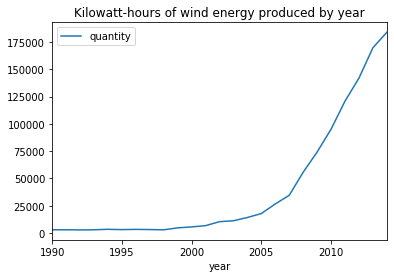

In [4]:
wind_results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours of wind energy produced by year")

In [5]:
sol_query = 'SELECT * FROM Energy WHERE category="solar_electricity";'

sol_results = pd.read_sql_query(sol_query, db)

sol_results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,17359,United States,Electricity - total solar production,2014,"Kilowatt-hours, million",24603.0,None,solar_electricity
1,17360,United States,Electricity - total solar production,2013,"Kilowatt-hours, million",15872.0,None,solar_electricity
2,17361,United States,Electricity - total solar production,2012,"Kilowatt-hours, million",10145.0,None,solar_electricity
3,17362,United States,Electricity - total solar production,2011,"Kilowatt-hours, million",6153.0,None,solar_electricity
4,17363,United States,Electricity - total solar production,2010,"Kilowatt-hours, million",3934.0,None,solar_electricity
5,17364,United States,Electricity - total solar production,2009,"Kilowatt-hours, million",2514.0,None,solar_electricity
6,17365,United States,Electricity - total solar production,2008,"Kilowatt-hours, million",2091.0,None,solar_electricity
7,17366,United States,Electricity - total solar production,2007,"Kilowatt-hours, million",1673.0,None,solar_electricity
8,17367,United States,Electricity - total solar production,2006,"Kilowatt-hours, million",1287.0,None,solar_electricity
9,17368,United States,Electricity - total solar production,2005,"Kilowatt-hours, million",1120.0,None,solar_electricity


Text(0.5, 1.0, 'Kilowatt-hours of solar energy produced by year')

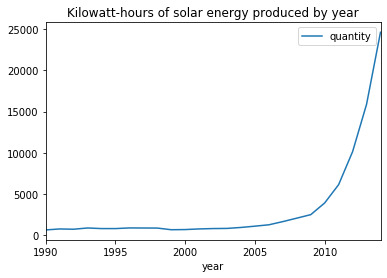

In [6]:
sol_results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours of solar energy produced by year")

In [7]:
hyd_query = 'SELECT * FROM Energy WHERE category="hydro";'

hyd_results = pd.read_sql_query(hyd_query, db)

hyd_results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,9058,United States,Electricity - total hydro production,2014,"Kilowatt-hours, million",281527.0,None,hydro
1,9059,United States,Electricity - total hydro production,2013,"Kilowatt-hours, million",290113.0,None,hydro
2,9060,United States,Electricity - total hydro production,2012,"Kilowatt-hours, million",298287.0,None,hydro
3,9061,United States,Electricity - total hydro production,2011,"Kilowatt-hours, million",344679.0,None,hydro
4,9062,United States,Electricity - total hydro production,2010,"Kilowatt-hours, million",286333.0,None,hydro
5,9063,United States,Electricity - total hydro production,2009,"Kilowatt-hours, million",298410.0,None,hydro
6,9064,United States,Electricity - total hydro production,2008,"Kilowatt-hours, million",281995.0,None,hydro
7,9065,United States,Electricity - total hydro production,2007,"Kilowatt-hours, million",275545.0,None,hydro
8,9066,United States,Electricity - total hydro production,2006,"Kilowatt-hours, million",317689.0,None,hydro
9,9067,United States,Electricity - total hydro production,2005,"Kilowatt-hours, million",297926.0,None,hydro


Text(0.5, 1.0, 'Kilowatt-hours of hydro energy produced by year in millions')

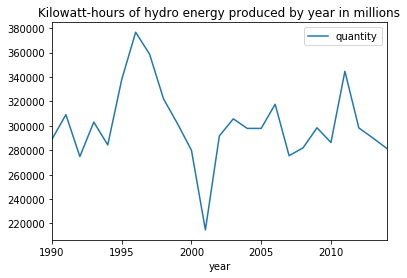

In [8]:
hyd_results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours of hydro energy produced by year in millions")

In [9]:
geo_query = 'SELECT * FROM Energy WHERE category="geothermal";'

geo_results = pd.read_sql_query(geo_query, db)

geo_results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,7523,United States,Electricity - total geothermal production,2014,"Kilowatt-hours, million",18710.0,None,geothermal
1,7524,United States,Electricity - total geothermal production,2013,"Kilowatt-hours, million",18422.0,None,geothermal
2,7525,United States,Electricity - total geothermal production,2012,"Kilowatt-hours, million",18135.0,None,geothermal
3,7526,United States,Electricity - total geothermal production,2011,"Kilowatt-hours, million",17892.0,None,geothermal
4,7527,United States,Electricity - total geothermal production,2010,"Kilowatt-hours, million",17577.0,None,geothermal
5,7528,United States,Electricity - total geothermal production,2009,"Kilowatt-hours, million",17046.0,None,geothermal
6,7529,United States,Electricity - total geothermal production,2008,"Kilowatt-hours, million",16873.0,None,geothermal
7,7530,United States,Electricity - total geothermal production,2007,"Kilowatt-hours, million",16798.0,None,geothermal
8,7531,United States,Electricity - total geothermal production,2006,"Kilowatt-hours, million",16581.0,None,geothermal
9,7532,United States,Electricity - total geothermal production,2005,"Kilowatt-hours, million",16778.0,None,geothermal


Text(0.5, 1.0, 'Kilowatt-hours of geothermal energy produced by year in millions')

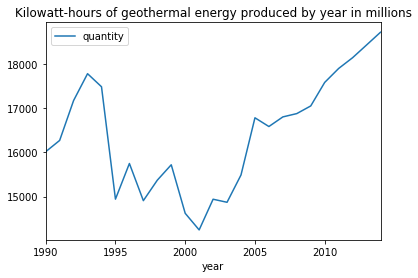

In [10]:
geo_results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours of geothermal energy produced by year in millions")

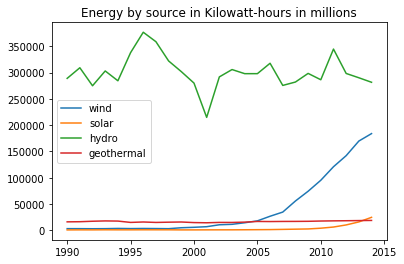

In [25]:
plt.subplots()

plt.plot(wind_results['year'], wind_results['quantity'])

plt.plot(sol_results['year'], sol_results['quantity'])

plt.plot(hyd_results['year'], hyd_results['quantity'])

plt.plot(geo_results['year'], geo_results['quantity'])

plt.title("Energy by source in Kilowatt-hours in millions")

plt.legend(['wind', 'solar', 'hydro', 'geothermal'])

In [11]:
tot_query = 'SELECT * FROM Energy WHERE commodity_transaction="Electricity - net production";'

tot_results = pd.read_sql_query(tot_query, db)

tot_results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,18732,United States,Electricity - net production,2014,"Kilowatt-hours, million",4122391.0,None,total_electricity
1,18733,United States,Electricity - net production,2013,"Kilowatt-hours, million",4093401.0,None,total_electricity
2,18734,United States,Electricity - net production,2012,"Kilowatt-hours, million",4077151.0,None,total_electricity
3,18735,United States,Electricity - net production,2011,"Kilowatt-hours, million",4133714.0,None,total_electricity
4,18736,United States,Electricity - net production,2010,"Kilowatt-hours, million",4157257.0,None,total_electricity
5,18737,United States,Electricity - net production,2009,"Kilowatt-hours, million",3978759.0,None,total_electricity
6,18738,United States,Electricity - net production,2008,"Kilowatt-hours, million",4152092.0,None,total_electricity
7,18739,United States,Electricity - net production,2007,"Kilowatt-hours, million",4190541.0,None,total_electricity
8,18740,United States,Electricity - net production,2006,"Kilowatt-hours, million",4097795.0,None,total_electricity
9,18741,United States,Electricity - net production,2005,"Kilowatt-hours, million",4087961.0,None,total_electricity


Text(0.5, 1.0, 'Kilowatt-hours total of energy produced by year in millions')

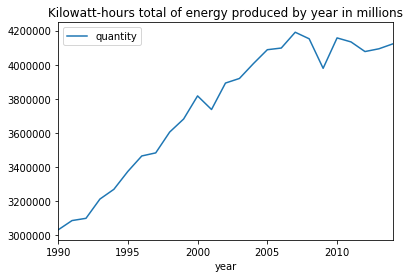

In [12]:
tot_results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours total of energy produced by year in millions")

In [16]:
ren_as_per = (wind_results['quantity'] + sol_results['quantity'] + hyd_results['quantity'] + geo_results['quantity']) / tot_results['quantity'] * 100

ren_as_per

0     12.340702
1     12.071136
2     11.490597
3     11.843538
4      9.693699
5      9.857244
6      8.589766
7      7.841923
8      8.839705
9      8.163116
10     8.203235
11     8.490196
12     8.169813
13     6.330586
14     7.885439
15     8.774657
16     9.470493
17    10.847842
18    11.453705
19    10.578191
20     9.367793
21    10.114798
22     9.545688
23    10.673536
24    10.188782
Name: quantity, dtype: float64

In [15]:
distinct = 'SELECT category, COUNT(*) AS NUMBER_OF_ENTRIES FROM Energy GROUP BY category;'

dis_show = pd.read_sql_query(distinct, db)

with pd.option_context('display.max_rows', 1104):
    display(dis_show)

,category,NUMBER_OF_ENTRIES
0,additives_and_oxygenates,168
1,animal_waste,269
2,anthracite,287
3,aviation_gasoline,247
4,bagasse,150
5,biodiesel,193
6,biogases,350
7,biogasoline,210
8,bitumen,256
9,black_liquor,168
